# Diffusion-Based-Conditional-Generative-Model

## The Dataset

Let's get started, below are the libraries used in this assessment.

In [1]:
import glob
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid

# User defined libraries
from utils import other_utils
from utils import ddpm_utils
from utils import UNet_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The FashionMnist dataset we used earlier is structurally similar to MNIST, so we will use much of the same code to load it. We will not randomly flip horizontally because numbers are not typically meant to be read backwards.

In [2]:
def load_MNIST(data_transform, train=True):
    return torchvision.datasets.MNIST(
        "./data/",
        download=True,
        train=train,
        transform=data_transform,
    )

def load_transformed_MNIST(img_size, batch_size):
    data_transforms = [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),  # Scales data into [0,1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_MNIST(data_transform, train=True)
    test_set = load_MNIST(data_transform, train=False)
    data = torch.utils.data.ConcatDataset([train_set, test_set])
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    return data, dataloader

The classifier model we will be challenging expects the image size to be `28 by 28` pixels. The images are also in black and white. There are `10` classes, one for each digit.

In [3]:
IMG_SIZE = 28
IMG_CH = 1
BATCH_SIZE = 128
N_CLASSES = 10
data, dataloader = load_transformed_MNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 129327574.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 46536954.98it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 239793744.90it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 25743957.79it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Setting Up Diffusion

Let's begin by setting up the diffusion process. In the interest of time, we have already listed the recommended hyperparameters for the `Beta` schedule below.

In [4]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)

In [5]:
a = 1.0 - B
a_bar = torch.cumprod(a, dim=0)
sqrt_a_bar = torch.sqrt(a_bar)  # Mean Coefficient
sqrt_one_minus_a_bar = torch.sqrt(1 - a_bar)  # St. Dev. Coefficient

# Reverse diffusion variables
sqrt_a_inv = torch.sqrt(1 / a)
pred_noise_coeff = (1 - a) / torch.sqrt(1 - a_bar)  # Predicted Noise Coefficient

In [6]:
def q(x_0, t):
        t = t.int()
        noise = torch.randn_like(x_0)
        sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
        sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

        x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
        return x_t, noise

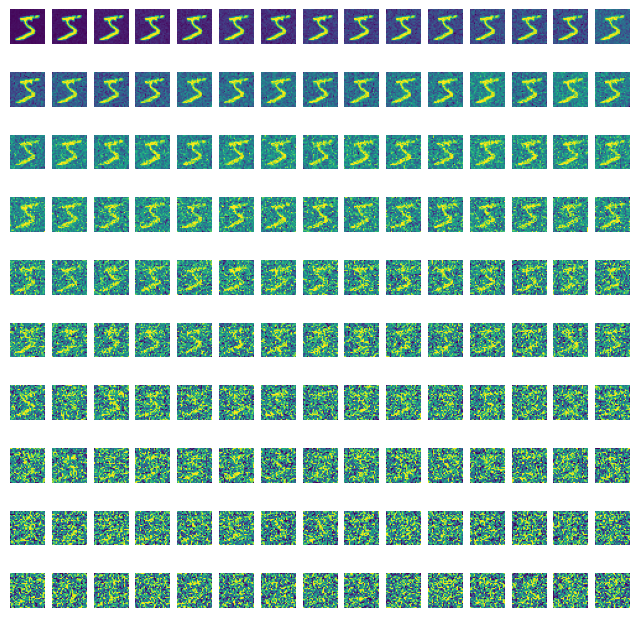

In [7]:
plt.figure(figsize=(8, 8))
x_0 = data[0][0].to(device)
xs = []

for t in range(T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, _ = q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis('off')
    other_utils.show_tensor_image(x_t)

In [22]:
@torch.no_grad()
def reverse_q(x_t, t, e_t):
    t = t.int()
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t[0] == 0:  # All t values should be the same
        return u_t  # Reverse diffusion complete!
    else:
        B_t = B[t - 1]  # Apply noise from the previos timestep
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

## Setting up a U-Net

In [9]:
class UNet(nn.Module):
    def __init__(
        self, T, img_ch, img_size, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=10
    ):
        super().__init__()
        self.T = T
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = img_size // 4  # 2 ** (len(down_chs) - 1)
        small_group_size = 8
        big_group_size = 32

        # Inital convolution
        self.down0 = ResidualConvBlock(img_ch, down_chs[0], small_group_size)

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size)
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size)
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * latent_image_size**2),
            nn.ReLU(),
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0])
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size)
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size)

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    def forward(self, x, t, c, c_mask):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / self.T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t)
        t_emb1 = self.t_emb1(t)
        t_emb2 = self.t_emb2(t)

        c = c * c_mask
        c_emb1 = self.c_embed1(c)
        c_emb2 = self.c_embed2(c)

        up0 = self.up0(latent_vec)
        up1 = self.up1(c_emb1 * up0 + t_emb1, down2)
        up2 = self.up2(c_emb2 * up1 + t_emb2, down1)
        return self.out(torch.cat((up2, down0), 1))

In [10]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [11]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [12]:
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [13]:
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

In [14]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [15]:
class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [16]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

Now that all the pieces have been defined, let's define the model.

In [17]:
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  2547457


## Model Training

In [18]:
def get_context_mask(c, drop_prob):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=N_CLASSES).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

In [19]:
def get_loss(model, x_0, t, *model_args):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy, t/T, *model_args)
    return F.mse_loss(noise, noise_pred)

This is mostly for our benefit to verify the model is training correctly.

In [20]:
def sample_images(model, img_ch, img_size, ncols, *model_args, axis_on=False):
    # Noise to generate images from
    x_t = torch.randn((1, img_ch, img_size, img_size), device=device)
    plt.figure(figsize=(8, 8))
    hidden_rows = T / ncols
    plot_number = 1

    # Go from T to 0 removing and adding noise until t = 0
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device).float()
        e_t = model(x_t, t, *model_args)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0:
            ax = plt.subplot(1, ncols+1, plot_number)
            if not axis_on:
                ax.axis('off')
            other_utils.show_tensor_image(x_t.detach().cpu())
            plot_number += 1
    plt.show()

Epoch 0 | Step 000 | Loss: 2.75540828704834 | C: 0


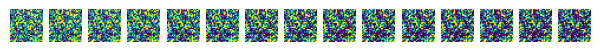

Epoch 0 | Step 100 | Loss: 0.06847503781318665 | C: 1


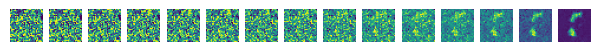

Epoch 0 | Step 200 | Loss: 0.06379400193691254 | C: 2


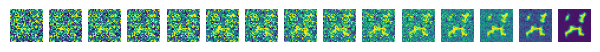

Epoch 0 | Step 300 | Loss: 0.046861063688993454 | C: 3


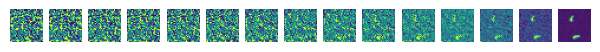

Epoch 0 | Step 400 | Loss: 0.041970591992139816 | C: 4


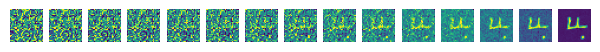

Epoch 0 | Step 500 | Loss: 0.04948553070425987 | C: 5


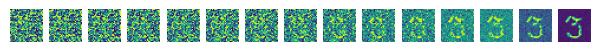

Epoch 1 | Step 000 | Loss: 0.05294903740286827 | C: 6


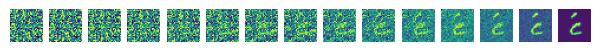

Epoch 1 | Step 100 | Loss: 0.041590262204408646 | C: 7


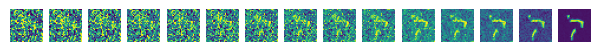

Epoch 1 | Step 200 | Loss: 0.0518086776137352 | C: 8


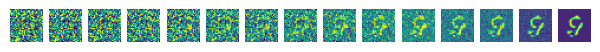

Epoch 1 | Step 300 | Loss: 0.047582440078258514 | C: 9


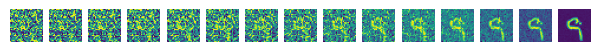

Epoch 1 | Step 400 | Loss: 0.04124346375465393 | C: 0


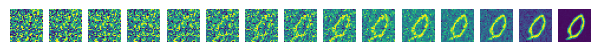

Epoch 1 | Step 500 | Loss: 0.03783769905567169 | C: 1


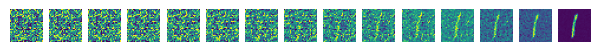

Epoch 2 | Step 000 | Loss: 0.034430332481861115 | C: 2


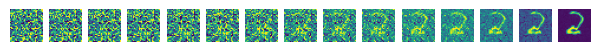

Epoch 2 | Step 100 | Loss: 0.040376078337430954 | C: 3


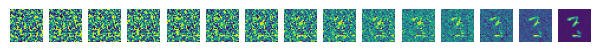

Epoch 2 | Step 200 | Loss: 0.0398046150803566 | C: 4


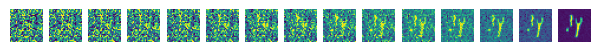

Epoch 2 | Step 300 | Loss: 0.03502083197236061 | C: 5


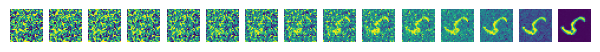

Epoch 2 | Step 400 | Loss: 0.03723526746034622 | C: 6


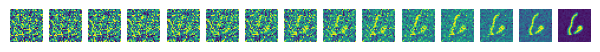

Epoch 2 | Step 500 | Loss: 0.04639338329434395 | C: 7


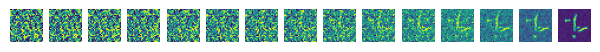

Epoch 3 | Step 000 | Loss: 0.03812790289521217 | C: 8


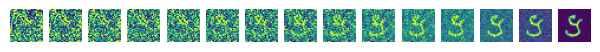

Epoch 3 | Step 100 | Loss: 0.039631474763154984 | C: 9


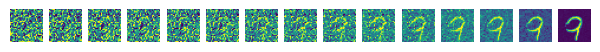

Epoch 3 | Step 200 | Loss: 0.03864133358001709 | C: 0


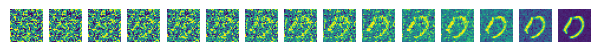

Epoch 3 | Step 300 | Loss: 0.038619689643383026 | C: 1


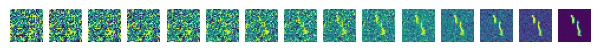

Epoch 3 | Step 400 | Loss: 0.0361819751560688 | C: 2


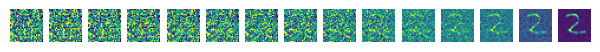

Epoch 3 | Step 500 | Loss: 0.03539350628852844 | C: 3


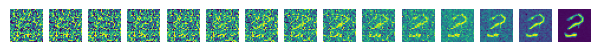

Epoch 4 | Step 000 | Loss: 0.0370427668094635 | C: 4


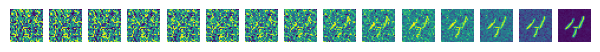

Epoch 4 | Step 100 | Loss: 0.03661235794425011 | C: 5


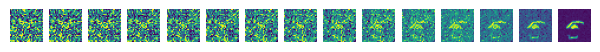

Epoch 4 | Step 200 | Loss: 0.03640391677618027 | C: 6


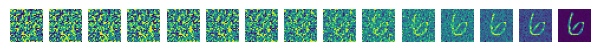

Epoch 4 | Step 300 | Loss: 0.0351225920021534 | C: 7


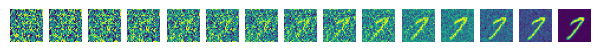

Epoch 4 | Step 400 | Loss: 0.032820478081703186 | C: 8


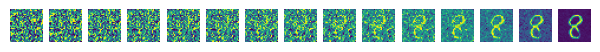

Epoch 4 | Step 500 | Loss: 0.03528066724538803 | C: 9


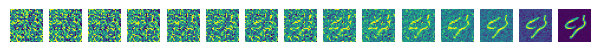

In [23]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 5
preview_c = 0

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        c_drop_prob = 0.1
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)  # New
        loss = get_loss(model, x, t, c_hot, c_mask)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} | C: {preview_c}")
            c_drop_prob = 0 # Do not drop context for preview
            c_hot, c_mask = get_context_mask(torch.Tensor([preview_c]), c_drop_prob)
            sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)
            preview_c = (preview_c + 1) % N_CLASSES

## Sampling

In [26]:
@torch.no_grad()
def sample_w(model, c, w):
    input_size = (IMG_CH, IMG_SIZE, IMG_SIZE)
    n_samples = len(c)
    w = torch.tensor([w]).float()
    w = w[:, None, None, None].to(device)  # Make w broadcastable
    x_t = torch.randn(n_samples, *input_size).to(device)

    # One c for each w
    c = c.repeat(len(w), 1)

    # Double the batch
    c = c.repeat(2, 1)

    # Don't drop context at test time
    c_mask = torch.ones_like(c).to(device)
    c_mask[n_samples:] = 0.0

    x_t_store = []
    for i in range(0, T)[::-1]:
        # Duplicate t for each sample
        t = torch.tensor([i]).to(device)
        t = t.repeat(n_samples, 1, 1, 1)

        # Double the batch
        x_t = x_t.repeat(2, 1, 1, 1)
        t = t.repeat(2, 1, 1, 1)

        # Find weighted noise
        e_t = model(x_t, t, c, c_mask)
        e_t_keep_c = e_t[:n_samples]
        e_t_drop_c = e_t[n_samples:]
        e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c

        # Deduplicate batch for reverse diffusion
        x_t = x_t[:n_samples]
        t = t[:n_samples]
        x_t = reverse_q(x_t, t, e_t)

    return x_t

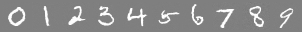

In [27]:
model.eval()
w = 0.1  # Change me
c = torch.arange(N_CLASSES).to(device)
c_drop_prob = 0 
c_hot, c_mask = get_context_mask(c, c_drop_prob)

x_0 = sample_w(model, c_hot, 1.0)
other_utils.to_image(make_grid(x_0.cpu(), nrow=N_CLASSES))

This is important for the automated grader. Is the output shape `[10, 1, 28, 28]`? If yes, you're ready to test the model!

In [28]:
x_0.shape

torch.Size([10, 1, 28, 28])

## Accuracy

In [29]:
from run_assessment import run_assessment

In [30]:
run_assessment(model, sample_w, w)

Evaluating model...

Classifier prediction for generated `0`: [0, 0, 0, 0, 0] - 100.0% Accuracy
Classifier prediction for generated `1`: [1, 1, 1, 1, 1] - 100.0% Accuracy
Classifier prediction for generated `2`: [8, 2, 3, 2, 2] - 60.0% Accuracy
Classifier prediction for generated `3`: [3, 3, 3, 3, 3] - 100.0% Accuracy
Classifier prediction for generated `4`: [4, 4, 4, 4, 4] - 100.0% Accuracy
Classifier prediction for generated `5`: [5, 5, 5, 5, 5] - 100.0% Accuracy
Classifier prediction for generated `6`: [6, 6, 6, 6, 6] - 100.0% Accuracy
Classifier prediction for generated `7`: [7, 7, 7, 2, 7] - 80.0% Accuracy
Classifier prediction for generated `8`: [8, 6, 8, 9, 8] - 60.0% Accuracy
Classifier prediction for generated `9`: [9, 9, 4, 9, 9] - 80.0% Accuracy
Final Accuracy - 88.0%

Accuracy required to pass the assessment is 95% or greater.
Your accuracy is not yet high enough to pass the assessment, please continue trying.
